**Necessary imports**

In [139]:
import os
import wrds
import pandas as pd
import warnings
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

**STEP 1 : data collection from wrds**

In [ ]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

Loading library list...
Done


In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2000-01-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf['date'] = pd.to_datetime(Rf['date'])

Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#Get the crsp value-weighted return index
query_crsp = """
SELECT date, vwretd, 
FROM crsp.msi
WHERE date BETWEEN '2000-01-01' AND '2024-12-31'
ORDER BY date;
"""

crsp_returns = db.raw_sql(query_crsp)
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})


crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

OperationalError: (psycopg2.OperationalError) could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out

[SQL: select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2000-01-01'
            and mcaldt<='2024-12-31']
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [512]:
crsp_returns = pd.read_csv('data/crsp_return.csv')

In [934]:
#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
def load_and_prepare_ir3(filepath, rename_dict):
    df = pd.read_csv(filepath).rename(columns=rename_dict)
    df['date'] = pd.to_datetime(df['date'])     
    df[df.columns[1]] /= 100
    return df.set_index('date')                 

# Load each series using the helper
ir3_japan = load_and_prepare_ir3("data/IR3TIB01JPM156N.csv", {"observation_date": "date", "IR3TIB01JPM156N": "ir3_jpn"})
ir3_fra   = load_and_prepare_ir3("data/IR3TIB01FRM156N.csv", {"observation_date": "date", "IR3TIB01FRM156N": "ir3_fra"})
ir3_gb    = load_and_prepare_ir3("data/IR3TIB01GBM156N.csv", {"observation_date": "date", "IR3TIB01GBM156N": "ir3_gb"})
ir3_us    = load_and_prepare_ir3("data/IR3TIB01USM156N.csv", {"observation_date": "date", "IR3TIB01USM156N": "ir3_us"})
ir3_aus   = load_and_prepare_ir3("data/IR3TIB01AUM156N.csv", {"observation_date": "date", "IR3TIB01AUM156N": "ir3_aus"})
ir3_ch    = load_and_prepare_ir3("data/IR3TIB01CHM156N.csv", {"observation_date": "date", "IR3TIB01CHM156N": "ir3_ch"})
ir3_deu   = load_and_prepare_ir3("data/IR3TIB01DEM156N.csv", {"observation_date": "date", "IR3TIB01DEM156N": "ir3_deu"})



# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/EXJPUS.csv").rename(columns={"observation_date": "date"})

df_jpy.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/EXSZUS.csv").rename(columns={"observation_date": "date"})
df_chf.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/EXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["EXUSAL"]


# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/EXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["EXUSEU"]

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/EXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["EXUSUK"]

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

country_data = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    country_data[code] = df



In [935]:
foreign_to_usd = pd.concat([
    df_jpy['EXJPUS'].rename("JPY_per_USD"),
    df_chf['EXSZUS'].rename("CHF_per_USD"),
    df_aud['AUD_per_USD'].rename("AUD_per_USD"),
    df_eur['EUR_per_USD'].rename("EUR_per_USD"),
    df_gbp['GBP_per_USD'].rename("GBP_per_USD")
], axis=1)
foreign_to_usd.index = df_jpy['date']

**Visualizing the data**

<Figure size 800x400 with 0 Axes>

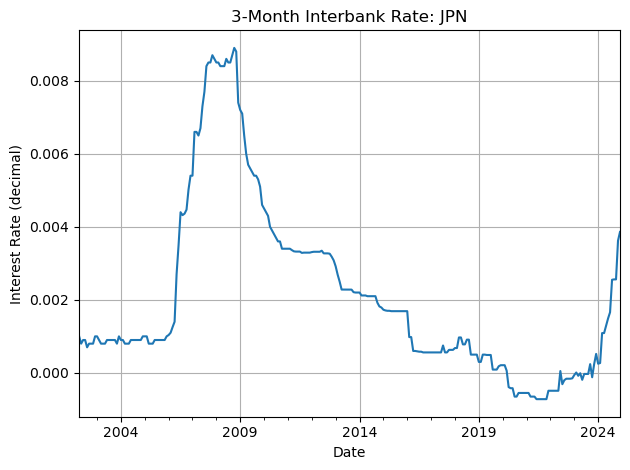

<Figure size 800x400 with 0 Axes>

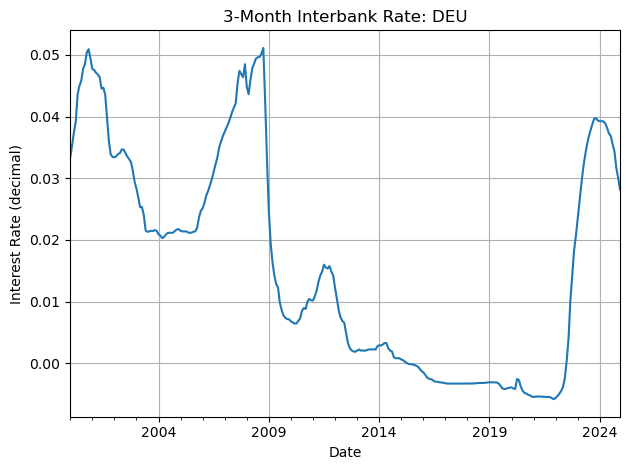

<Figure size 800x400 with 0 Axes>

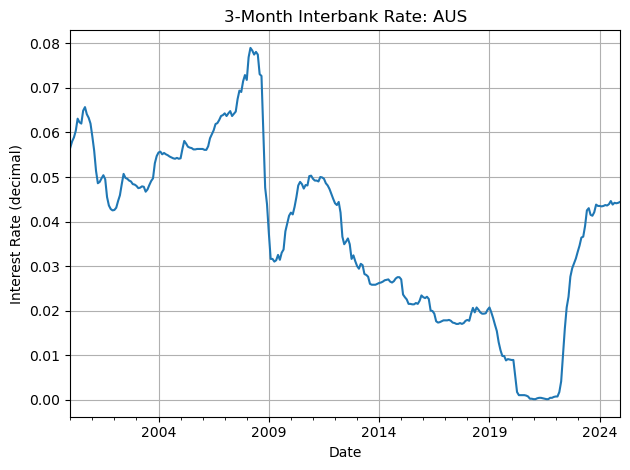

<Figure size 800x400 with 0 Axes>

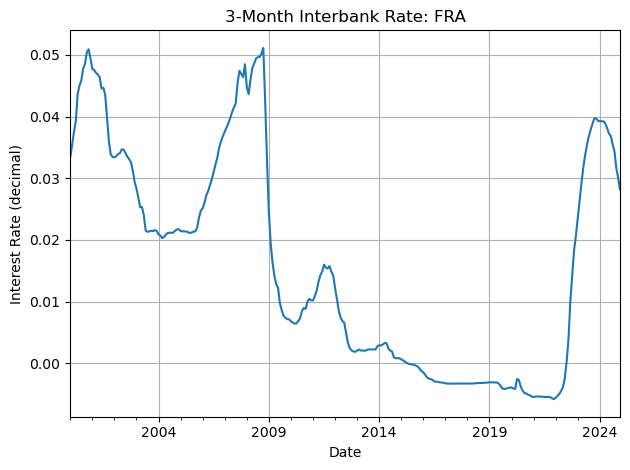

<Figure size 800x400 with 0 Axes>

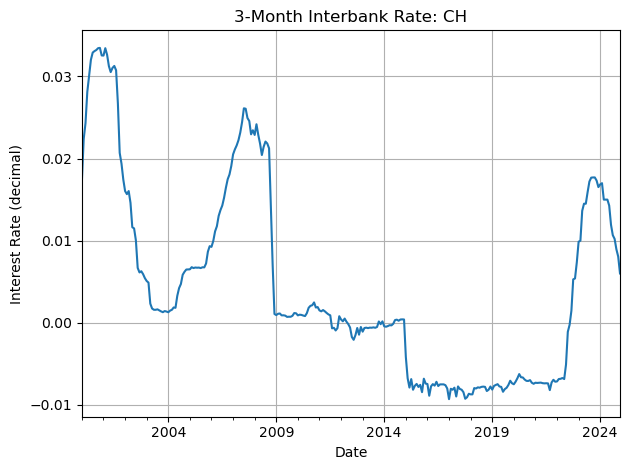

<Figure size 800x400 with 0 Axes>

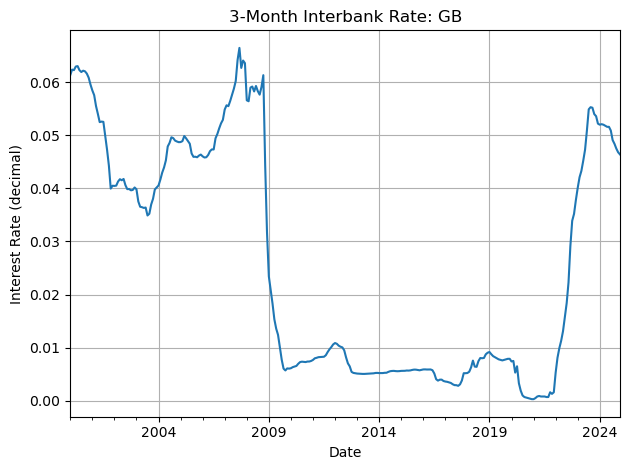

<Figure size 800x400 with 0 Axes>

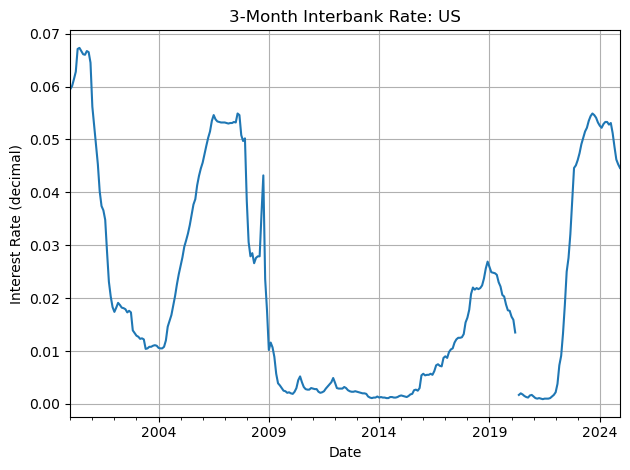

In [936]:
import matplotlib.pyplot as plt
ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb,
    'us' : ir3_us
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**We observe a missing value in 2020 for the us interbank rate, to replace it we will use interpolation**

In [937]:
ir3_us = ir3_us.interpolate(method='time')

<Axes: xlabel='date'>

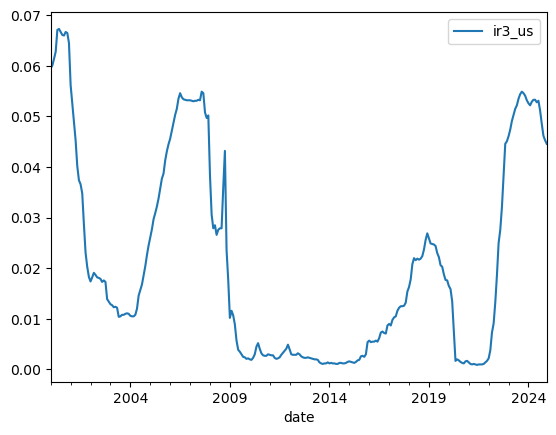

In [938]:
ir3_us.plot()

**Now it is interpolated, and all our data is continuous ! **

In [939]:
#Merge all the interbank together for ease
ir3_all = pd.concat(
    [df.rename(columns={df.columns[0]: f'ir3_{code}'}) for code, df in ir3_data.items()],
    axis=1,
    join='outer'
)


**Let's plot the exchange rate**

<Figure size 1000x400 with 0 Axes>

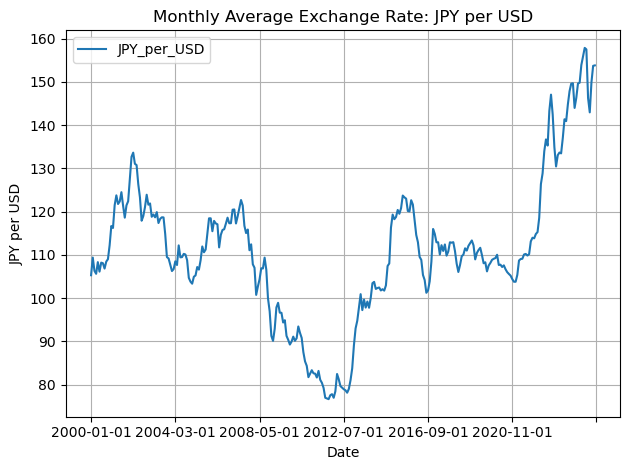

<Figure size 1200x600 with 0 Axes>

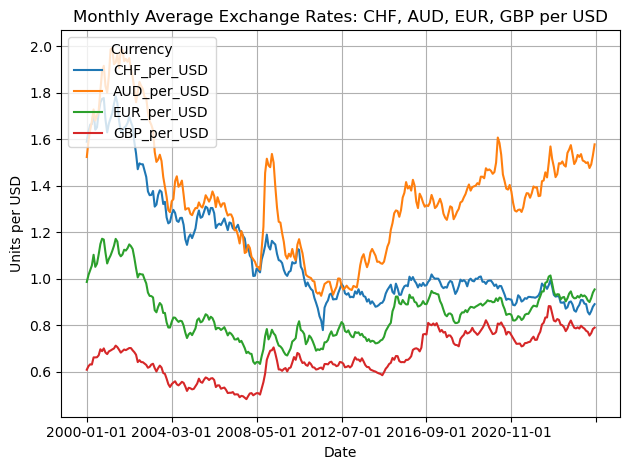

In [940]:
# Separate JPY from others
monthly_jpy = foreign_to_usd[['JPY_per_USD']]
monthly_others = foreign_to_usd.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

### Foreign Index Return in USD

The formula to convert a foreign index return to USD is:

$$
R_{DC} = (1 + R_{FC}) \cdot (1 + R_{FX}) - 1
$$

Where:

- \( R_{DC} \): Return in domestic currency (USD)  
- \( R_{FC} \): Return in foreign currency  
- \( R_{FX} \): Return on the exchange rate (foreign per USD)


Returns can be expressed as $\log{\frac{R_{t}}{R_t - 1}}$

In [941]:
ret_exchange_rate = np.log(foreign_to_usd/foreign_to_usd.shift(1)) 
ret_exchange_rate.dropna(inplace=True)
ret_exchange_rate = ret_exchange_rate.drop(ret_exchange_rate.index[0])

ret_exchange_rate.sort_index(inplace=True)

def convert_foreign_to_usd(ret_foreign_currency, ret_exchange_rate) :
    return (1 + ret_foreign_currency)*(1 + ret_exchange_rate) - 1  


#Convert for each country

jpn = country_data['jpn']
jpn = jpn.drop(jpn.index[0])
jpn['mportret']  = convert_foreign_to_usd(jpn['mportret'],  ret_exchange_rate['JPY_per_USD'].values)



aus = country_data['aus']
aus = aus.drop(aus.index[0])
aus['mportret']  = convert_foreign_to_usd(aus['mportret'],  ret_exchange_rate['AUD_per_USD'].values)



deu = country_data['deu']
deu = deu.drop(deu.index[0])
deu['mportret']  = convert_foreign_to_usd(deu['mportret'],  ret_exchange_rate['EUR_per_USD'].values)



fra = country_data['fra']
fra = fra.drop(fra.index[0])
fra['mportret']  = convert_foreign_to_usd(fra['mportret'],  ret_exchange_rate['EUR_per_USD'].values)


ch = country_data['ch']
ch = ch.drop(ch.index[0])
ch['mportret']  = convert_foreign_to_usd(ch['mportret'],  ret_exchange_rate['CHF_per_USD'].values)



gb = country_data['gb']
gb = gb.drop(gb.index[0])
gb['mportret']  = convert_foreign_to_usd(gb['mportret'],  ret_exchange_rate['GBP_per_USD'].values)




jpn = jpn[['date', 'country', 'mportret']]
aus = aus[['date', 'country', 'mportret']]
deu = deu[['date', 'country', 'mportret']]
fra = fra[['date', 'country', 'mportret']]
ch  = ch[['date', 'country', 'mportret']]
gb  = gb[['date', 'country', 'mportret']]

crsp_returns['country'] = 'US'
crsp_returns.drop(columns='Unnamed: 0')
crsp_returns.rename(columns={'vwretd': 'mportret'}, inplace=True)

crsp_returns = crsp_returns.copy().drop(crsp_returns.index[0])

#Merge
merged_all = pd.concat([jpn, aus, deu, fra, ch, gb, crsp_returns], axis=0, ignore_index=True)
merged_all = merged_all.drop(columns='Unnamed: 0')

merged_all['date'] = pd.to_datetime(merged_all['date'])


In [942]:
merged_all

,date,country,mportret
0,2000-02-29,JAPAN,-0.015010
1,2000-03-31,JAPAN,-0.012927
2,2000-04-28,JAPAN,-0.012339
3,2000-05-31,JAPAN,-0.093123
4,2000-06-30,JAPAN,0.067781
...,...,...,...
2074,2024-07-31,US,0.019878
2075,2024-08-30,US,0.021572
2076,2024-09-30,US,0.020969
2077,2024-10-31,US,-0.008298


**PROBLEM WITH AUStralia We neED to find what. The following is to see why** 

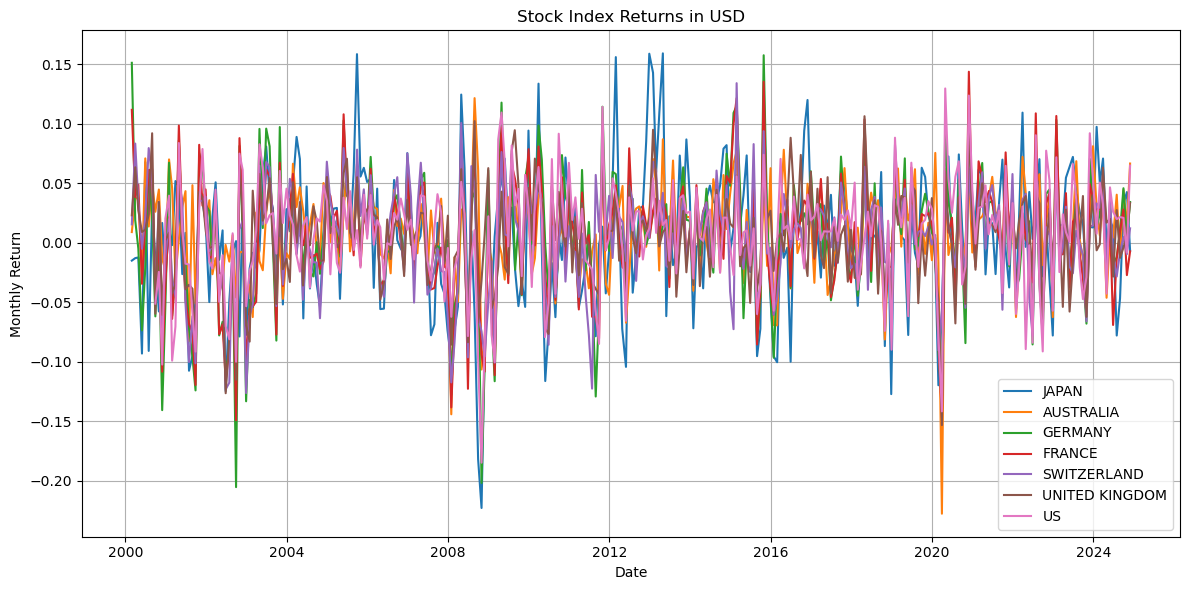

In [943]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in merged_all['country'].unique():
    subset = merged_all[merged_all['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [944]:
import matplotlib.pyplot as plt

def compare_countries(merged_all, country1, country2, return_type='mportret'):
    """
    Plot cumulative returns in USD of two countries from the merged_all dataframe.
    
    Parameters:
        merged_all (DataFrame): Combined dataset with 'date', 'country', and return columns.
        country1, country2 (str): Country names to compare (must match 'country' column values).
        return_type (str): Either 'mportret' (unhedged) or 'mportretx' (hedged).
    """
    df1 = merged_all[merged_all['country'] == country1][['date', return_type]].copy()
    df2 = merged_all[merged_all['country'] == country2][['date', return_type]].copy()

    # Merge on date to ensure strict alignment
    df = df1.merge(df2, on='date', suffixes=(f'_{country1}', f'_{country2}'))

    # Compute cumulative returns
    df[f'cumulative_{country1}'] = (1 + df[f'{return_type}_{country1}']).cumprod()
    df[f'cumulative_{country2}'] = (1 + df[f'{return_type}_{country2}']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[f'cumulative_{country1}'], label=country1, linewidth=2)
    plt.plot(df['date'], df[f'cumulative_{country2}'], label=country2, linewidth=2)
    plt.title(f'Cumulative Return in USD: {country1} vs {country2}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Start = 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


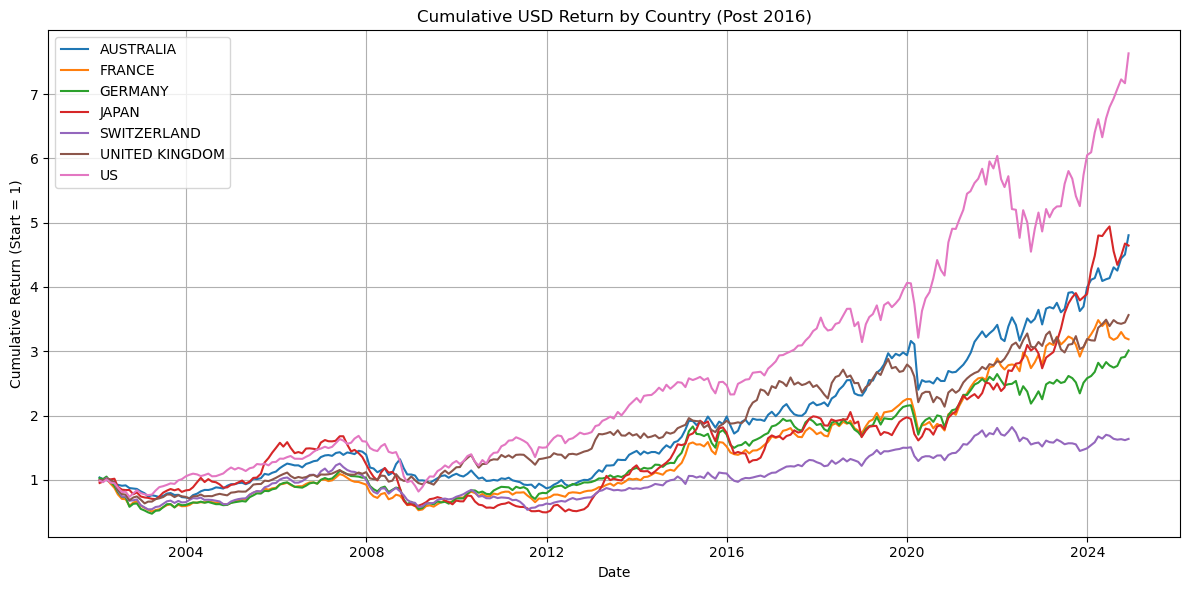

In [945]:
merged_all_filtered = merged_all[merged_all['date'] > '2002-01-01']

plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country, group in merged_all_filtered.groupby('country'):
    cumulative = (1 + group['mportret']).cumprod()
    plt.plot(group['date'], cumulative, label=country)

plt.title('Cumulative USD Return by Country (Post 2016)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Currency-Hedged Excess Return in USD

The formula for the **excess return** in USD from a $1 investment in the Euro-currency hedged via shorting the foreign currency is:

$$
X_{t+1}^{\text{EU}} = \frac{S_{t+1}}{S_t}(1 + r^{\text{EU}}) - (1 + r^{\text{US}})
$$

Where:

- \( X_{t+1}^{\text{EU}} \): Excess return in USD from the currency-hedged investment in the Euro-currency  
- \( S_t \): Spot exchange rate at time \( t \), in USD per EUR  
- \( S_{t+1} \): Spot exchange rate at time \( t+1 \), in USD per EUR  
- \( r^{\text{EU}} \): Risk-free interest rate in the Eurozone over the period  
- \( r^{\text{US}} \): Risk-free interest rate in the US over the period  


Get USD per euro 

In [951]:
usd_to_foreign = 1/foreign_to_usd
usd_to_foreign.columns =  [f'USD_PER_{col.split("_")[0]}' for col in usd_to_foreign.columns]


#J'ai drop trop d'index on doit changer 


proportion = usd_to_foreign.shift(-1)/usd_to_foreign
proportion = proportion.dropna()

ir3_filtered = ir3_all.drop(ir3_all.index[-1])

excess_return = pd.DataFrame()

excess_return['JAPAN'] = proportion['USD_PER_JPY'].values*(1 + ir3_filtered['ir3_jpn']) - (1 + ir3_filtered['ir3_us'])
excess_return['FRANCE'] = proportion['USD_PER_EUR'].values*(1 + ir3_filtered['ir3_fra']) - (1 + ir3_filtered['ir3_us'])
excess_return['AUSTRALIA'] = proportion['USD_PER_AUD'].values*(1 + ir3_filtered['ir3_aus']) - (1 + ir3_filtered['ir3_us'])
excess_return['GERMANY'] = proportion['USD_PER_EUR'].values*(1 + ir3_filtered['ir3_deu']) - (1 + ir3_filtered['ir3_us'])
excess_return['UNITED KINGDOM'] = proportion['USD_PER_GBP'].values*(1 + ir3_filtered['ir3_gb']) - (1 + ir3_filtered['ir3_us'])
excess_return['SWITZERLAND'] = proportion['USD_PER_CHF'].values*(1 + ir3_filtered['ir3_ch']) - (1 + ir3_filtered['ir3_us'])


hedge_return = pd.DataFrame()

country = [
    'JAPAN',
    'FRANCE',
    'GERMANY',
    'AUSTRALIA',
    'SWITZERLAND',
    'UNITED KINGDOM'
]


# Compute hedged return for each country
for country  in country:
    df = merged_all[merged_all['country'] == country]
    df = df.drop(df.index[-1])
    excess = excess_return.drop(excess_return.index[[0, 1]])
    hedge_return[country] = df['mportret'].values - excess[country].values
    hedge_return.index = excess.index #Need to modify not good practice
    


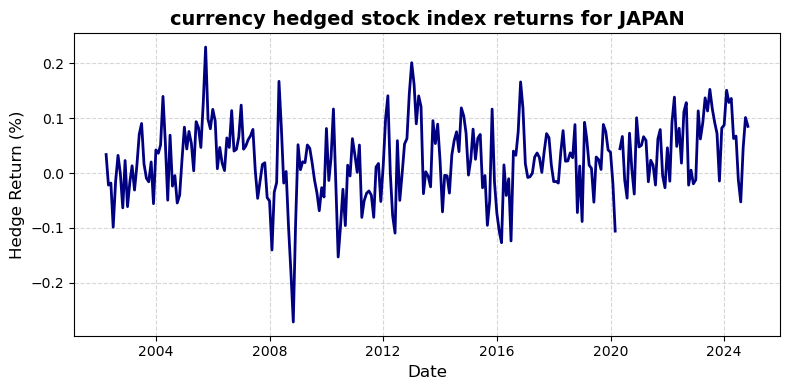

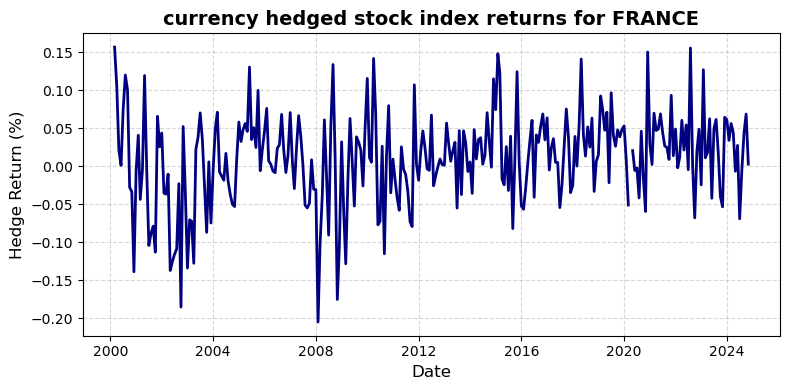

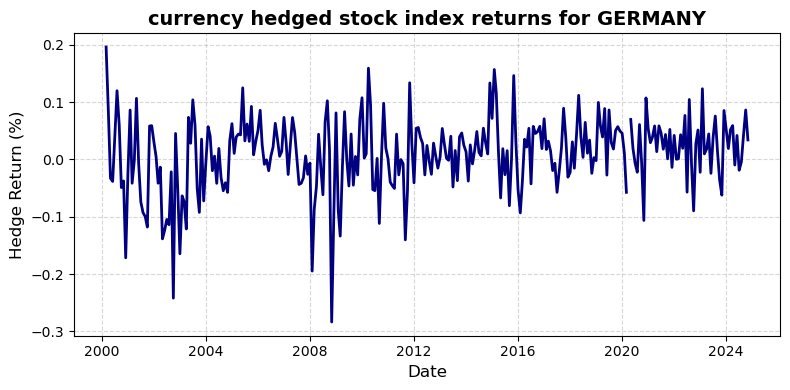

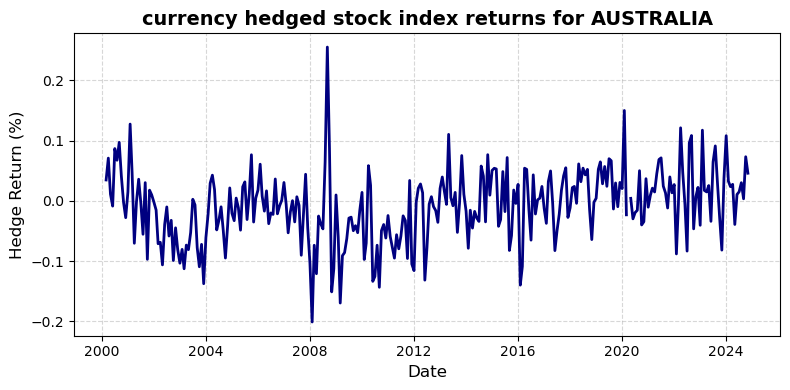

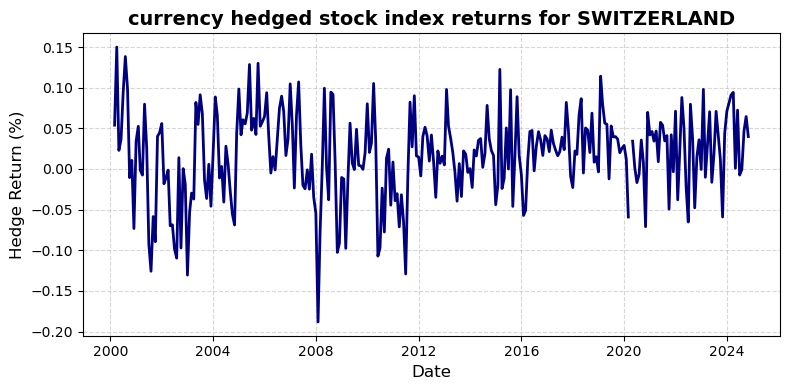

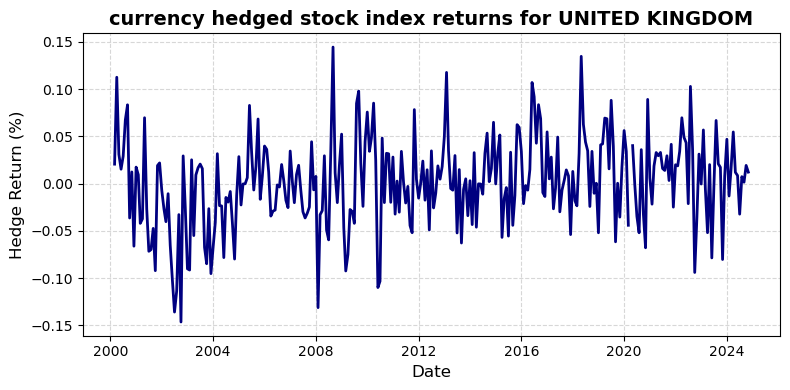

In [960]:
for country in hedge_return.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(hedge_return[country], color='navy', linewidth=2)
    plt.title(f'currency hedged stock index returns for {country.upper()}', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Hedge Return (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()